In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import cartopy.crs as ccrs
import os
#from pyproj import CRS
import geopandas as gpd
#from pykrige.ok import OrdinaryKriging
from osgeo import osr
from osgeo import gdal
from scipy.spatial import distance_matrix
#from scipy.interpolate import Rbf
import rasterio as rio
import itertools as it
from pyproj import Transformer, CRS

path_data = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'USGS_mineralmap')
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

In [2]:
# Read and intersect the valid data
alldata = []
for i,layer in enumerate(['A','C'], 3):
    data = pd.read_excel(os.path.join(path_data, f'Appendix_{i}a_{layer}horizon_18Sept2013.xls'), 
                        skiprows = 12).iloc[1:, :]
    data = data.loc[:, ['SiteID', 'Latitude', 'Longitude', 'LandCover1', 'LandCover2',
                        f'{layer}_Depth', f'{layer}_Kaolinit', f'{layer}_Calcite']
                   ].dropna(subset = [f'{layer}_Kaolinit', f'{layer}_Calcite'], how = 'all')
    data['SiteID'] = data['SiteID'].astype(int)
    data = data.rename({f'{layer}_Depth': 'Depth',
                        f'{layer}_Kaolinit': 'Kaolinit', 
                        f'{layer}_Calcite': 'Calcite'}, axis = 1)
    # N.D. indicates an undetected mineral phase.
    data.replace('N.D.', 0., inplace=True)

    # skip the depths that starts with '<', '>', 'N.S', 'Not recorded'
    data = data.loc[[not (d.startswith('<') or d.startswith('>') or d == 'N.S.' \
                     or d == 'Not recorded' or d == 'not recorded') for d in data['Depth']], :]
    
    # N.S. indicates not a sample, in Kaolinit & Calcite columns
    data.replace('N.S.', np.nan, inplace = True)
    data['Kaolinit'] = data['Kaolinit'].astype(float)
    data['Calcite'] = data['Calcite'].astype(float)

    # separate the depth range, convert from cm to m
    data['hzn_top'] = [float(d.split('-')[0])/100 for d in data['Depth']]
    data['hzn_bot'] = [float(d.split('-')[1])/100 for d in data['Depth']]
    data = data.drop('Depth', axis = 1)

    alldata.append(data)
alldata = pd.concat(alldata, axis = 0).sort_values(by = 'hzn_top')
# drop NA; fortunately, they are common between Kaolinit and Calcite
alldata = alldata.dropna(axis = 0, how = 'all', subset = ['Kaolinit', 'Calcite'])
alldata

,SiteID,Latitude,Longitude,LandCover1,LandCover2,Kaolinit,Calcite,hzn_top,hzn_bot
4822,10043,41.6240,-110.9207,Shrubland,Shrubland,1.9,5.5,0.00,0.03
3196,7164,39.9656,-83.4528,Planted/Cultivated,Row Crops,3.0,0.0,0.00,0.25
3195,6908,39.7261,-83.2184,Planted/Cultivated,Small Grains,1.5,0.0,0.00,0.23
3194,6736,41.4631,-83.2989,Planted/Cultivated,Row Crops,0.0,0.0,0.00,0.24
3193,6524,40.0718,-81.2417,Developed,Low Intensity Residential,6.9,0.0,0.00,0.10
...,...,...,...,...,...,...,...,...,...
1055,12776,40.7173,-92.9936,Planted/Cultivated,Row Crops,0.0,0.0,1.38,1.65
1031,9448,40.6756,-91.3687,Planted/Cultivated,Row Crops,0.0,0.0,1.39,1.67
998,4888,41.2588,-95.2893,Planted/Cultivated,Row Crops,2.2,0.0,1.40,1.57
4278,3643,40.6473,-112.3082,Developed,Low Intensity Residential,0.0,14.9,1.40,1.57


## 1. Check data availability

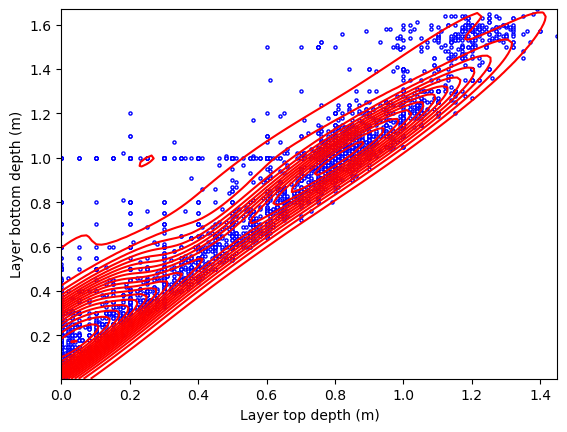

In [3]:
x = alldata['hzn_top'].values
y = alldata['hzn_bot'].values
#y = y[x < 30]
#x = x[x < 30]
kde = gaussian_kde([x[::100], y[::100]])

# Creating a grid of values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

fig, ax = plt.subplots()
ax.scatter(x, y, s=5, facecolor='white', edgecolor='blue')
ax.contour(Xgrid, Ygrid, Z, colors='red', levels=20)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 50])
ax.set_xlabel('Layer top depth (m)')
ax.set_ylabel('Layer bottom depth (m)')
plt.show()

0    1864
1    1592
2    1217
3       5
4       0
dtype: int64

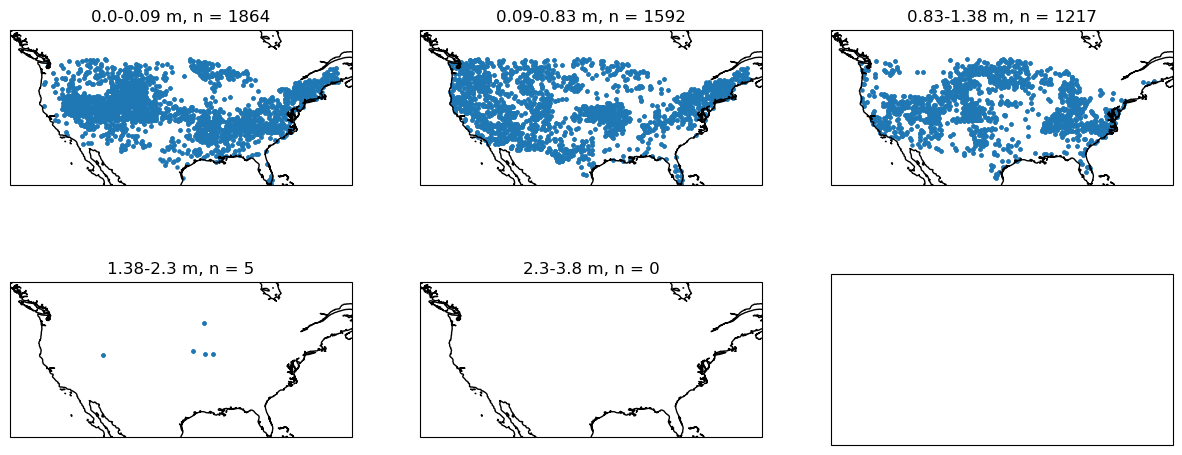

In [4]:
# convert from m to cm; Table 6.1 Soil Layer structure, CLM4.5 doc
# Merge the top 10cm into one because too few observations
# 0.0175, 0.0451, 0.0906, 
# Merge the 10-80cm into one because too few observations
# 0.1655, 0.2891, 0.4929, 0.8289
# Below 1.38m doesn't have much data; use relaxed criteria here then
# 1.3828, 2.2961, 3.8019, merge those layers too
elm_bot = np.array([0.0906,  0.8289, 1.3828, 2.2961, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

num_obs = pd.Series(0, index = range(len(elm_bot)))

fig, axes = plt.subplots(2, 3, figsize = (15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.01 allows some inaccuracies
    straddle_top = alldata.query('hzn_top > @top_above and hzn_top < (@top+0.01) and hzn_bot > @top and hzn_bot < @bottom').set_index('SiteID')

    # layer starts in the layer, and ends one layer below
    # 0.01 allows some inaccuracies
    straddle_bot = alldata.query('hzn_top > @top and hzn_top < @bottom and hzn_bot > (@bottom-0.01) and hzn_bot < @bot_below').set_index('SiteID')

    # layer fully within
    # 0.01 allows some inaccuracies
    middle = alldata.query('hzn_top >= (@top - 0.01) and hzn_bot <= (@bottom + 0.01)').set_index('SiteID')

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers (there
    # may be additional layers in the middle that we do not care)
    site_with_obs = middle.index.union(straddle_top.index.intersection(straddle_bot.index))
    bool_obs = alldata['SiteID'].isin(site_with_obs)

    # Check the number of points for individual cations
    #for col in lab_chemical_properties.columns:
    #    site_subset = lab_chemical_properties.loc[~lab_chemical_properties[col].isna(), 'site_key'].drop_duplicates()
    #    num_obs.loc[i, col] = len(has_obs.intersection(list(site_subset)))
    num_obs.loc[i] = len(site_with_obs)

    ax = axes.flat[i]
    ax.coastlines()
    ax.set_extent([-130, -65, 25, 50])
    ax.scatter(alldata.loc[bool_obs, 'Longitude'], alldata.loc[bool_obs, 'Latitude'], s = 5)
    ax.set_title(f'{np.around(top,2)}-{np.around(bottom,2)} m, n = {num_obs.loc[i]}')
num_obs

## 2. Perform depth interpolation

In [15]:
elm_bot = np.array([0.0906,  0.8289, 1.3828])
elm_top = np.insert(elm_bot[:-1], 0, 0)

xlswriter = pd.ExcelWriter(os.path.join(path_out, 'interp_soilMineral.xlsx'), engine='openpyxl')

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.01 allows some inaccuracies
    straddle_top = (alldata['hzn_top'] > top_above) & (alldata['hzn_top'] < top) & \
        (alldata['hzn_bot'] > top) & (alldata['hzn_bot'] < bottom)

    # layer starts in the layer, and ends one layer below
    # 0.01 allows some inaccuracies
    straddle_bot = (alldata['hzn_top'] > top) & (alldata['hzn_top'] < bottom) & \
        (alldata['hzn_bot'] > bottom) & (alldata['hzn_bot'] < bot_below)

    # layer fully within
    # 0.01 allows some inaccuracies
    middle = (alldata['hzn_top'] >= top) & (alldata['hzn_bot'] <= bottom)

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers (there
    # may be additional layers in the middle that we do not care)
    siteid_straddle = set(alldata.loc[straddle_top, 'SiteID']) & \
        set(alldata.loc[straddle_bot, 'SiteID'])
    bool_obs = middle | ((straddle_top | straddle_bot) & (alldata['SiteID'].isin(siteid_straddle)))

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers
    site_with_obs = alldata.loc[bool_obs, 'SiteID'].drop_duplicates()
    interp_values = pd.DataFrame(np.nan, 
                                 index = site_with_obs,
                                 columns = ['Kaolinit', 'Calcite', 'Latitude', 'Longitude'])

    # perform weighted average using the fraction overlapping with the layer; 
    #     note in addition to straddle_top and straddle_bot, there may be 
    #     other observations not covering the whole layer
    to_interpolate = alldata.loc[bool_obs, :]

    overlap_thickness = pd.Series(
        np.minimum(to_interpolate.loc[:, 'hzn_bot'].values, bottom) - \
        np.maximum(to_interpolate.loc[:, 'hzn_top'].values, top),
        index = to_interpolate['SiteID'])

    total_thickness = overlap_thickness.groupby('SiteID').sum()
    total_thickness = np.array([total_thickness.loc[id] for id in overlap_thickness.index])

    layer_weight = overlap_thickness / total_thickness

    for col in ['Kaolinit', 'Calcite']:
        weighted_sum = (to_interpolate[col].values * layer_weight).groupby('SiteID').sum()
        interp_values.loc[weighted_sum.index, col] = weighted_sum.values

    interp_values.loc[:, ['Latitude','Longitude']] = \
        alldata.loc[bool_obs, ['SiteID', 'Latitude', 'Longitude']].groupby('SiteID').first()

    interp_values.to_excel(xlswriter, sheet_name = f'layer_{i}')
xlswriter.close()

## 3. Perform spatial interpolation

Save to geotiff

In [6]:
dummy() # stop here; change to the geo kernel

NameError: name 'dummy' is not defined

In [ ]:
def idw_interpolation(x, y, z, xi, yi, power=2):
    distances = distance_matrix(np.column_stack([x, y]), np.column_stack([xi.ravel(), yi.ravel()]))
    weights = 1.0 / distances**power
    weights /= weights.sum(axis=0)
    zi = np.dot(weights.T, z)
    return zi.reshape(xi.shape)

In [ ]:
""" Need to run this on a server to have enough memory """
elm_bot = np.array([0.0906,  0.8289, 1.3828])
elm_top = np.insert(elm_bot[:-1], 0, 0)

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    interp_values = pd.read_excel(os.path.join(path_out, 'interp_soilMineral.xlsx'), 
                                  sheet_name = f'layer_{i}', index_col = 0)

    for j, col in enumerate(['Kaolinit', 'Calcite']):

        values = interp_values[[col]].dropna()
        gdf = interp_values.loc[:, [col, 'Latitude', 'Longitude']]
        gdf = gpd.GeoDataFrame(gdf,
                               geometry=gpd.points_from_xy(gdf['Longitude'], gdf['Latitude']),
                               crs='EPSG:4326')

        # Converting lat-lon to a projected coordinate system for distance accuracy
        gdf = gdf.to_crs('EPSG:5070') # OC

        # gdf.to_file(os.path.join('..', 'results', f'interp_NCSS_layer_{i}_{col}.shp'))

        # Extract coordinates and values
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        values = gdf[col].values.astype(np.float32)

        # Create a grid where interpolation will be performed
        grid_x = np.arange(np.around(min(x)), np.around(max(x)) + 200000, 10000)
        grid_y = np.arange(np.around(max(y)) + 100000, np.around(min(y)) - 100000, -10000)
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)

        z = idw_interpolation(x, y, values, grid_x, grid_y)

        """# Perform Ordinary Kriging
        ok = OrdinaryKriging(
            x, y, values,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False
        )
        z, ss = ok.execute('grid', grid_x, grid_y)"""

        # use gdal to save to geotiff
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(5070)

        geotransform = (grid_x[0, 0], 10000, 0, grid_y[0, 0], 0, -10000)

        gdal_data_type = gdal.GDT_Float32

        # Create the file
        driver = gdal.GetDriverByName('GTiff')
        output_file = os.path.join(path_out, f'interp_soilMineral_layer_{i}_{col}.tif')
        dataset = driver.Create(output_file, z.shape[1], z.shape[0], 1, gdal_data_type)

        # Set the geotransform and projection
        dataset.SetGeoTransform(geotransform)
        dataset.SetProjection(srs.ExportToWkt())

        # Get the raster band
        band = dataset.GetRasterBand(1)

        # Write the array to band
        band.WriteArray(z)
        band.SetNoDataValue(np.nan)  # Assuming 'nan' is your no-data value

        # Clean up
        band.FlushCache()
        dataset = None